In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from timeit import default_timer
from DefFunciones import *
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [2]:
#### DBSCAN ####

def neighborsgen(X, point, eps, metric, X_distances):
    
    neighbors = []
    if X_distances == 0:
        for i in range(X.shape[0]):
            if metric(X[point], X[i]) < eps:
                neighbors.append(i)
    else:
        for i in range(X.shape[0]):
            if X[point][i] < eps:
                neighbors.append(i)
                
    return neighbors

def expand_clusters(X, clusters, point, neighbors, C, eps, minPts, metric, X_distances):
    clusters[point] = C
    
    k = 0
    while k < len(neighbors):
        
        newPoint = neighbors[k]
        
        if clusters[newPoint] == -1:
            clusters[newPoint] = C
        
        elif clusters[newPoint] == 0:
            clusters[newPoint] = C
            
            nextNeighbors = neighborsgen(X, newPoint, eps, metric, X_distances)
            
            if len(nextNeighbors) >= minPts:
                neighbors = neighbors + nextNeighbors
                
        k += 1

def DBSCAN_prop_1(X, eps, minPts, metric = distance.euclidean, X_distances = 0):
    
    clusters = [0] * X.shape[0]
    cl = [i for i in range(len(clusters))]
    C = 0
    
    if X_distances == 0:
        while len(cl) > 0:
            
            p = np.random.choice(cl)
            #for p in range(0, X.shape[0]):
            if clusters[p] == 0:
                
                neighbors = neighborsgen(X, p, eps, metric, X_distances = 0)
                
                if len(neighbors) < minPts:
                    clusters[p] = -1
                
                else:
                    C += 1
                    expand_clusters(X,clusters, p, neighbors, C, eps, minPts, metric, X_distances = 0)
                cl.pop(cl.index(p))
            
            else:
                cl.pop(cl.index(p))
        
    
    else:
        while len(cl) > 0:
            
            p = np.random.choice(cl)
        #for p in range(0, X.shape[0]):
            if clusters[p] == 0:
                
                neighbors = neighborsgen(X, p, eps, metric, X_distances = 1)
                
                if len(neighbors) < minPts:
                    clusters[p] = -1
                
                else:
                    C += 1
                    expand_clusters(X,clusters, p, neighbors, C, eps, minPts, metric, X_distances = 1)
                    
                cl.pop(cl.index(p))
            
            else:
                cl.pop(cl.index(p))
                
                
    return clusters

In [3]:
X_2 = np.loadtxt('X_2.txt') # Preprocesar noticias falsas

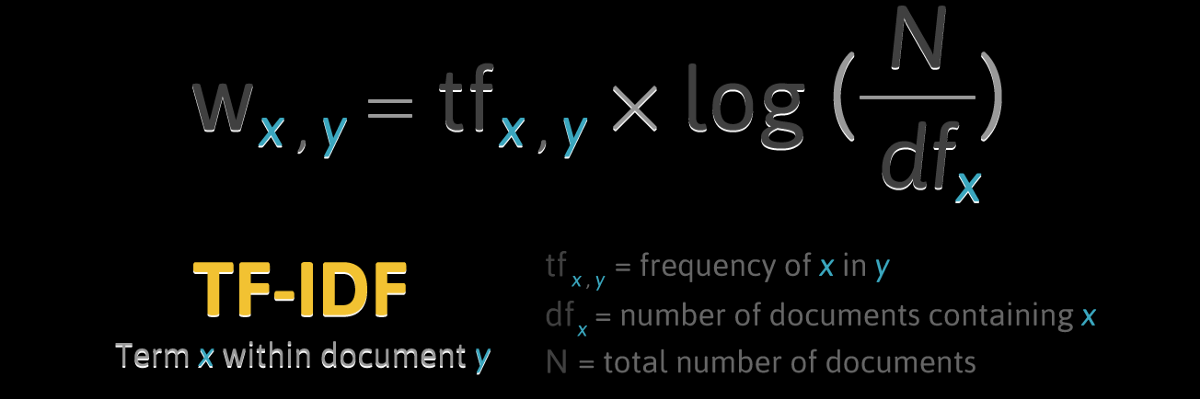

In [4]:
X_2.shape

(676, 13883)

In [5]:
### Train ###
train = pd.read_excel('train.xlsx', index_col = 'Id')
train['Category'] = np.where(train['Category'] == 'Fake', 1,-1)
### Test ###
test = pd.read_excel('development.xlsx', index_col = 'Id')
test['Category'] = np.where(test['Category'] == 'Fake', 1,-1)
corpus_train = [re.sub('[^\w\s]|\d','', s.lower()) for s in train['Text']]
corpus_train = [re.sub('\n',' ', s.lower()) for s in corpus_train]
corpus_test = [re.sub('[^\w\s]|\d','', s.lower()) for s in test['Text']]
corpus_test = [re.sub('\n',' ', s.lower()) for s in corpus_test]

In [6]:
from sklearn.decomposition import PCA
pca = PCA()
pca_ = pca.fit(X_2)

----------------------------------------------------
Porcentaje de varianza explicada por cada componente
----------------------------------------------------


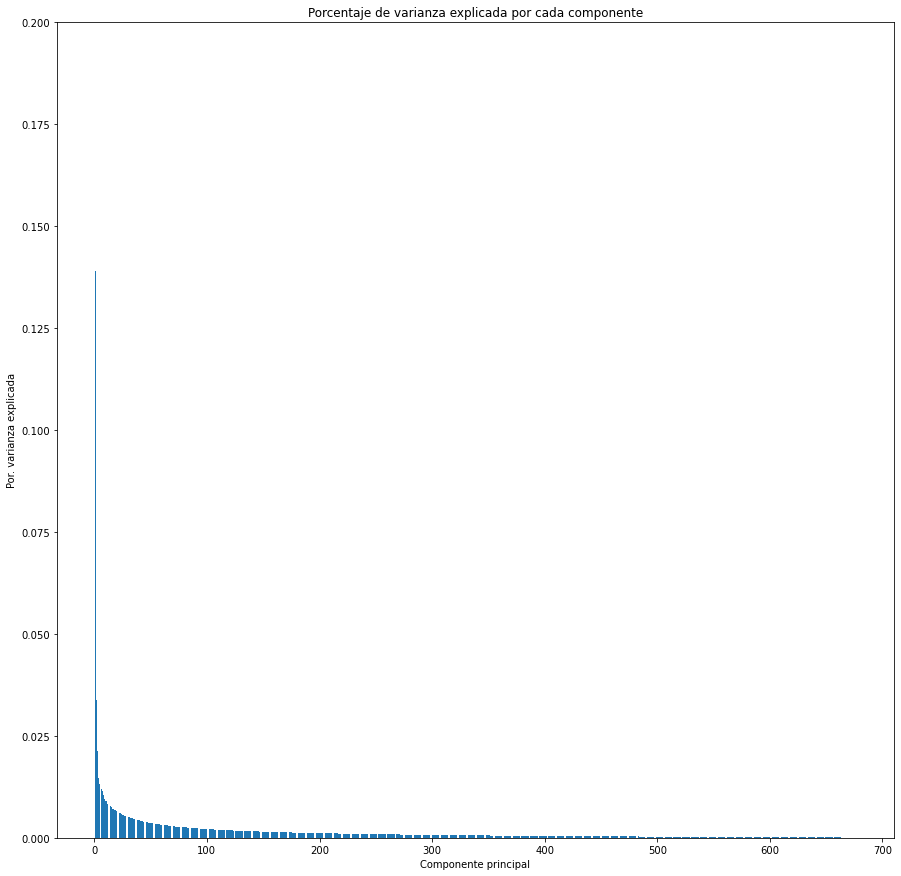

In [7]:
# Porcentaje de varianza explicada por cada componente
# ==============================================================================
print('----------------------------------------------------')
print('Porcentaje de varianza explicada por cada componente')
print('----------------------------------------------------')
#print(pca_.explained_variance_ratio_)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
ax.bar(
    x      = np.arange(pca_.n_components_) + 1,
    height = pca_.explained_variance_ratio_
)


ax.set_ylim(0, 0.2)
ax.set_title('Porcentaje de varianza explicada por cada componente')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza explicada');

------------------------------------------
Porcentaje de varianza explicada acumulada
------------------------------------------


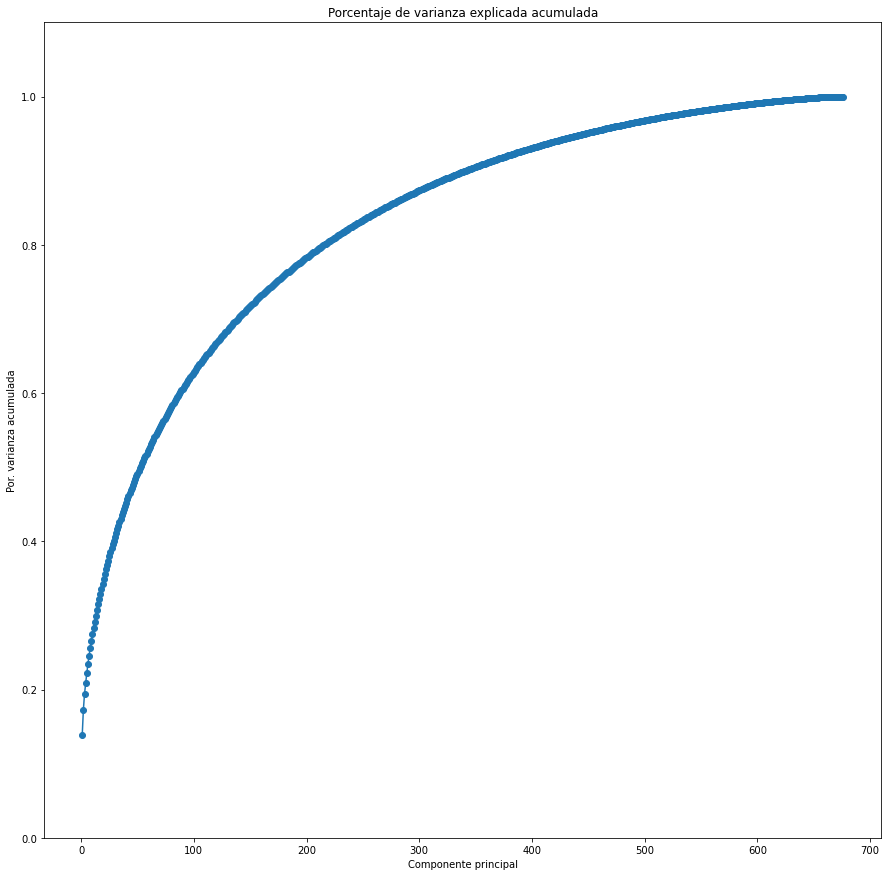

In [8]:
# Porcentaje de varianza explicada acumulada
# ==============================================================================
prop_varianza_acum = pca.explained_variance_ratio_.cumsum()
print('------------------------------------------')
print('Porcentaje de varianza explicada acumulada')
print('------------------------------------------')
#print(prop_varianza_acum)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
ax.plot(
    np.arange(pca_.n_components_) + 1,
    prop_varianza_acum,
    marker = 'o'
)

# for x, y in zip(np.arange(pca_.n_components_)) + 1, prop_varianza_acum):
#     label = round(y, 2)
#     ax.annotate(
#         label,
#         (x,y),
#         textcoords="offset points",
#         xytext=(0,10),
#         ha='center'
#     )
    
ax.set_ylim(0, 1.1)
#ax.set_xticks(np.arange(pca.n_components_) + 1)
ax.set_title('Porcentaje de varianza explicada acumulada')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza acumulada');

In [9]:
## Con 10 componentes
pca = PCA(n_components = 10)
pca_2 = pca.fit_transform(X_2)

In [10]:
clusters_eucl_10 = []
for n in [5,10,15, 20, 25]:
    for m in [.5,1.0,1.5,2.0, 2.5, 3.0,3.5]:
        clusters_eucl_10.append((DBSCAN_prop_1(pca_2, m, n, metric = distance.euclidean, X_distances = 0), m, n))     

In [11]:
mat_cos = np.zeros((len(pca_2), len(pca_2)))
for i in range(len(pca_2)):
    for j in range(i, len(pca_2)-1):
        mat_cos[i][j+1] = distance.euclidean(pca_2[i], pca_2[j+1])
mat_cos = mat_cos.T + mat_cos

In [12]:
mat_cos.max()

91.7213612294832

In [13]:
clusters_cos_10 = []
for n in [5,10,15,20,25]:
    for m in [0.15, 0.12, 0.21, 0.25, 0.35, 0.45, 0.5]:
        clusters_cos_10.append((DBSCAN_prop_1(pca_2, m, n, metric = distance.cosine, X_distances = 0), m, n))

In [14]:
mat_cos = np.zeros((len(pca_2), len(pca_2)))
for i in range(len(pca_2)):
    for j in range(i, len(pca_2)-1):
        mat_cos[i][j+1] = distance.cosine(pca_2[i], pca_2[j+1])
mat_cos = mat_cos.T + mat_cos

In [15]:
for i in range(35):
    if len(set(clusters_eucl_10[i][0])) <= 2:
         print(set(clusters_eucl_10[i][0]), clusters_eucl_10[i][0].count(1), clusters_eucl_10[i][0].count(-1), 
          'eps: ' + str(clusters_eucl_10[i][1]), 'minPts: ' + str(clusters_eucl_10[i][2]),
          'Precision: ' + str(precision_score(train['Category'],clusters_eucl_10[i][0])),
          'Recall: ' + str(recall_score(train['Category'],clusters_eucl_10[i][0])),
          'F1: ' + str(f1_score(train['Category'],clusters_eucl_10[i][0])),
          'Accuracy: ' + str(accuracy_score(train['Category'],clusters_eucl_10[i][0]))
         )

{-1} 0 676 eps: 0.5 minPts: 5 Precision: 0.0 Recall: 0.0 F1: 0.0 Accuracy: 0.5
{1, -1} 5 671 eps: 1.0 minPts: 5 Precision: 0.8 Recall: 0.011834319526627219 F1: 0.023323615160349854 Accuracy: 0.5044378698224852
{1, -1} 308 368 eps: 2.5 minPts: 5 Precision: 0.698051948051948 Recall: 0.636094674556213 F1: 0.6656346749226005 Accuracy: 0.6804733727810651
{1, -1} 455 221 eps: 3.5 minPts: 5 Precision: 0.6 Recall: 0.8076923076923077 F1: 0.6885245901639345 Accuracy: 0.6346153846153846
{-1} 0 676 eps: 0.5 minPts: 10 Precision: 0.0 Recall: 0.0 F1: 0.0 Accuracy: 0.5
{-1} 0 676 eps: 1.0 minPts: 10 Precision: 0.0 Recall: 0.0 F1: 0.0 Accuracy: 0.5
{1, -1} 192 484 eps: 2.0 minPts: 10 Precision: 0.71875 Recall: 0.40828402366863903 F1: 0.520754716981132 Accuracy: 0.6242603550295858
{1, -1} 282 394 eps: 2.5 minPts: 10 Precision: 0.7056737588652482 Recall: 0.5887573964497042 F1: 0.6419354838709677 Accuracy: 0.6715976331360947
{1, -1} 352 324 eps: 3.0 minPts: 10 Precision: 0.6676136363636364 Recall: 0.6952

C:\Users\Angel\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
for i in range(35):
    if len(set(clusters_cos_10[i][0])) <= 2:
         print(set(clusters_cos_10[i][0]), clusters_cos_10[i][0].count(1), clusters_cos_10[i][0].count(-1), 
          'eps: ' + str(clusters_cos_10[i][1]), 'minPts: ' + str(clusters_cos_10[i][2]),
          'Precision: ' + str(precision_score(train['Category'],clusters_cos_10[i][0])),
          'Recall: ' + str(recall_score(train['Category'],clusters_cos_10[i][0])),
          'F1: ' + str(f1_score(train['Category'],clusters_cos_10[i][0])),
          'Accuracy: ' + str(accuracy_score(train['Category'],clusters_cos_10[i][0]))
         )

{1, -1} 610 66 eps: 0.21 minPts: 5 Precision: 0.521311475409836 Recall: 0.9408284023668639 F1: 0.6708860759493671 Accuracy: 0.5384615384615384
{1, -1} 644 32 eps: 0.25 minPts: 5 Precision: 0.5124223602484472 Recall: 0.9763313609467456 F1: 0.6720977596741343 Accuracy: 0.5236686390532544
{1, -1} 674 2 eps: 0.35 minPts: 5 Precision: 0.5 Recall: 0.9970414201183432 F1: 0.66600790513834 Accuracy: 0.5
{1} 676 0 eps: 0.45 minPts: 5 Precision: 0.5 Recall: 1.0 F1: 0.6666666666666666 Accuracy: 0.5
{1} 676 0 eps: 0.5 minPts: 5 Precision: 0.5 Recall: 1.0 F1: 0.6666666666666666 Accuracy: 0.5
{1, -1} 561 115 eps: 0.21 minPts: 10 Precision: 0.5418894830659536 Recall: 0.8994082840236687 F1: 0.6763070077864294 Accuracy: 0.5695266272189349
{1, -1} 624 52 eps: 0.25 minPts: 10 Precision: 0.5240384615384616 Recall: 0.9674556213017751 F1: 0.6798336798336797 Accuracy: 0.5443786982248521
{1, -1} 673 3 eps: 0.35 minPts: 10 Precision: 0.49925705794947994 Recall: 0.9940828402366864 F1: 0.6646884272997032 Accuracy

In [17]:
clusters_eucl_2 = []
for n in [23, 24, 25, 26, 27, 28]:
    for m in [2.5,2.6,2.7,2.8,2.9,3.0,3.1,3.2,3.3,3.4,3.5]:
        clusters_eucl_2.append((DBSCAN_prop_1(pca_2, m, n, metric = distance.euclidean, X_distances = 0), m, n)) 

In [18]:
minPts = []
eps = []
precision = []
accuracy = []
mean = []
for i in range(66):
    if len(set(clusters_eucl_2[i][0])) <= 2:
        minPts.append(clusters_eucl_2[i][2])
        eps.append(clusters_eucl_2[i][1])
        precision.append(precision_score(train['Category'],clusters_eucl_2[i][0]))
        accuracy.append(accuracy_score(train['Category'],clusters_eucl_2[i][0]))
        mean.append((precision_score(train['Category'],clusters_eucl_2[i][0]) + accuracy_score(train['Category'],clusters_eucl_2[i][0]))/2)

In [19]:
for i in range(66):
    if len(set(clusters_eucl_2[i][0])) <= 2:
        print(set(clusters_eucl_2[i][0]), clusters_eucl_2[i][0].count(1), clusters_eucl_2[i][0].count(-1), 
          'eps: ' + str(clusters_eucl_2[i][1]), 'minPts: ' + str(clusters_eucl_2[i][2]),
          'Precision: ' + str(precision_score(train['Category'],clusters_eucl_2[i][0])),
          'Recall: ' + str(recall_score(train['Category'],clusters_eucl_2[i][0])),
          'F1: ' + str(f1_score(train['Category'],clusters_eucl_2[i][0])),
          'Accuracy: ' + str(accuracy_score(train['Category'],clusters_eucl_2[i][0]))
         )

{1, -1} 249 427 eps: 2.5 minPts: 23 Precision: 0.7108433734939759 Recall: 0.5236686390532544 F1: 0.6030664395229982 Accuracy: 0.6553254437869822
{1, -1} 271 405 eps: 2.6 minPts: 23 Precision: 0.7158671586715867 Recall: 0.5739644970414202 F1: 0.6371100164203612 Accuracy: 0.6730769230769231
{1, -1} 283 393 eps: 2.7 minPts: 23 Precision: 0.7173144876325088 Recall: 0.6005917159763313 F1: 0.6537842190016102 Accuracy: 0.6819526627218935
{1, -1} 295 381 eps: 2.8 minPts: 23 Precision: 0.7152542372881356 Recall: 0.6242603550295858 F1: 0.6666666666666666 Accuracy: 0.6878698224852071
{1, -1} 316 360 eps: 2.9 minPts: 23 Precision: 0.6993670886075949 Recall: 0.6538461538461539 F1: 0.6758409785932721 Accuracy: 0.6863905325443787
{1, -1} 332 344 eps: 3.0 minPts: 23 Precision: 0.6867469879518072 Recall: 0.6745562130177515 F1: 0.6805970149253732 Accuracy: 0.6834319526627219
{1, -1} 345 331 eps: 3.1 minPts: 23 Precision: 0.6782608695652174 Recall: 0.6923076923076923 F1: 0.6852122986822841 Accuracy: 0.68

In [20]:
## 2.9, 28
# precision = []
# recall = []
# f1 = []
# accuracy = []
# k = 0
# while k < 10:
#     clusters = DBSCAN_prop_1(pca_2, 2.9, 28, metric = distance.euclidean, X_distances = 0)
#     if len(set(clusters)) <= 2:
#         precision.append(precision_score(train['Category'],clusters))
#         recall.append(recall_score(train['Category'],clusters))
#         f1.append(f1_score(train['Category'],clusters))
#         accuracy.append(accuracy_score(train['Category'],clusters))
#     else:
#         precision.append(("Nulo", m, n))
#         recall.append(("Nulo", m, n))
#         f1.append(("Nulo", m, n))
#         accuracy.append(("Nulo", m, n))
#     k+= 1

In [21]:
%matplotlib notebook
## 2.9, 28
plt.figure(figsize=(5,5))
sns.scatterplot(
    x = pca_2[:, 0], y = pca_2[:, 1],
    style = DBSCAN_prop_1(pca_2, 2.9, 28, metric = distance.euclidean, X_distances = 0),
    hue = train['Category'],
    alpha=0.3, palette="deep"
)

<IPython.core.display.Javascript object>

<AxesSubplot:>

In [22]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
x = pca_2[:, 0]
y = pca_2[:, 1]
z = pca_2[:, 2]
ax.scatter(x, y, z, c = DBSCAN_prop_1(pca_2, 2.9, 28, metric = distance.euclidean, X_distances = 0))
#ax.set_xlabel('num_chars')
#ax.set_ylabel('num_digits')
#ax.set_zlabel('num_other')
plt.show()

<IPython.core.display.Javascript object>

In [23]:
### Prueba
X_2_d = np.loadtxt('X_2_d.txt')

In [24]:
## Aplicamos PCA
pca_2_d = pca.fit_transform(X_2_d)

In [25]:
## Obtenemos los cluster con mejor precision, accuracy y mejor promedio
##(eps = 2.5, minpts = 29)
clusters_max_prec = DBSCAN_prop_1(pca_2, eps[precision.index(max(precision))],
                                  minPts[precision.index(max(precision))], metric = distance.euclidean, X_distances = 0)
##(eps = 2.9, minpts = 27)
clusters_max_acc = DBSCAN_prop_1(pca_2, eps[accuracy.index(max(accuracy))], 
                                 minPts[accuracy.index(max(accuracy))], metric = distance.euclidean, X_distances = 0)
#clusters_max_prec = (minPts[precision.index(max(precision))], eps[precision.index(max(precision))]) ##(eps = 2.9, minpts = 27)

In [26]:
## Clusters DBSCAN con la mejor precision y accuracy (eps = 2.9, minpts = 28)
clusters_max_prec_acc = DBSCAN_prop_1(pca_2, 2.9, 28, metric = distance.euclidean, X_distances = 0)

In [27]:
## Función que calcula la matriz de distancias entre los nuevos puntos sin clasificar y los nuevos puntos y devuelve los 
## nuevos clusters
def new_clust(X_1, X, clusters):
    mat_dist = np.zeros((len(X_1), len(X)))
    for i in range(len(X_1)):
        for j in range(len(X)):
            mat_dist[i][j] = distance.euclidean(X_1[i], X[j])
    nuevos_clust = []
    for i in range(len(mat_dist)):
        index = np.argmin(np.ma.masked_where(mat_dist[i] == 0, mat_dist[i]))
        nuevos_clust.append(clusters[index])
    return nuevos_clust

In [28]:
### Precisión y accuracy minPts = 28 eps = 2.9
print('Precision', precision_score(test['Category'], new_clust(pca_2_d,pca_2, clusters_max_prec_acc)))
print('Recall', recall_score(test['Category'], new_clust(pca_2_d,pca_2, clusters_max_prec_acc)))
print('F1 Score', f1_score(test['Category'], new_clust(pca_2_d,pca_2, clusters_max_prec_acc)))
print('Accuracy', accuracy_score(test['Category'], new_clust(pca_2_d,pca_2, clusters_max_prec_acc)))

Precision 0.5722222222222222
Recall 0.7253521126760564
F1 Score 0.639751552795031
Accuracy 0.6067796610169491


In [29]:
### Precision
print('Precision', precision_score(test['Category'], new_clust(pca_2_d,pca_2, clusters_max_prec)))
print('Recall', recall_score(test['Category'], new_clust(pca_2_d,pca_2, clusters_max_prec)))
print('F1 Score', f1_score(test['Category'], new_clust(pca_2_d,pca_2, clusters_max_prec)))
print('Accuracy', accuracy_score(test['Category'], new_clust(pca_2_d,pca_2, clusters_max_prec)))

Precision 0.5632911392405063
Recall 0.6267605633802817
F1 Score 0.5933333333333333
Accuracy 0.5864406779661017


In [30]:
## Accuracy
print('Precision', precision_score(test['Category'], new_clust(pca_2_d,pca_2, clusters_max_acc)))
print('Recall', recall_score(test['Category'], new_clust(pca_2_d,pca_2, clusters_max_acc)))
print('F1 Score', f1_score(test['Category'], new_clust(pca_2_d,pca_2, clusters_max_acc)))
print('Accuracy', accuracy_score(test['Category'], new_clust(pca_2_d,pca_2, clusters_max_acc)))

Precision 0.5722222222222222
Recall 0.7253521126760564
F1 Score 0.639751552795031
Accuracy 0.6067796610169491


In [31]:
## Función que calcula la matriz de distancias entre los nuevos puntos sin clasificar y los puntos clasificadosy devuelve los 
## nuevos clusters, además de las anomalías
def new_cl_an(X_1, X, clusters, eps): ## X_1 puntos nuevos, X puntos clasificados, clusters de X, eps de clusters de X
    mat_dist = np.zeros((len(X_1), len(X)))
    for i in range(len(X_1)):
        for j in range(len(X)):
            mat_dist[i][j] = distance.euclidean(X_1[i], X[j])
    nuevos_clust = []
    for i in range(len(mat_dist)):
        index = np.argmin(np.ma.masked_where(mat_dist[i] == 0, mat_dist[i]))
        if mat_dist[i][index] < eps:
            nuevos_clust.append(clusters[index])
        else: 
            nuevos_clust.append(99)
    return nuevos_clust

In [32]:
new_cl_an(pca_2_d,pca_2, clusters_max_prec_acc, 2.9)

[99,
 99,
 1,
 1,
 99,
 99,
 1,
 -1,
 1,
 99,
 99,
 1,
 1,
 1,
 99,
 99,
 99,
 99,
 1,
 99,
 1,
 1,
 1,
 -1,
 99,
 99,
 1,
 99,
 99,
 99,
 99,
 1,
 -1,
 1,
 1,
 99,
 99,
 1,
 1,
 99,
 -1,
 99,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 99,
 99,
 1,
 1,
 -1,
 99,
 1,
 -1,
 1,
 99,
 99,
 1,
 99,
 1,
 1,
 1,
 99,
 1,
 1,
 99,
 1,
 99,
 99,
 1,
 99,
 1,
 99,
 1,
 1,
 1,
 1,
 99,
 99,
 99,
 1,
 1,
 1,
 99,
 1,
 1,
 1,
 1,
 1,
 99,
 1,
 -1,
 1,
 99,
 99,
 99,
 99,
 1,
 1,
 1,
 99,
 99,
 99,
 99,
 99,
 -1,
 99,
 99,
 99,
 1,
 99,
 1,
 1,
 99,
 99,
 99,
 1,
 99,
 1,
 1,
 99,
 1,
 1,
 -1,
 99,
 1,
 1,
 1,
 99,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 99,
 99,
 99,
 99,
 99,
 1,
 99,
 1,
 1,
 99,
 99,
 99,
 99,
 1,
 99,
 -1,
 1,
 99,
 1,
 1,
 99,
 99,
 1,
 1,
 99,
 99,
 99,
 1,
 99,
 99,
 99,
 -1,
 1,
 99,
 1,
 99,
 1,
 1,
 99,
 1,
 99,
 1,
 -1,
 99,
 99,
 99,
 99,
 1,
 99,
 1,
 1,
 99,
 99,
 99,
 1,
 99,
 99,
 99,
 99,
 99,
 1,
 99,
 1,
 99,
 99,
 1,
 99,
 1,

In [33]:
### Precisión y accuracy minPts = 28 eps = 2.9
#print('Precision', precision_score(test['Category'], new_cl_an(pca_2_d,pca_2, clusters_max_prec_acc, 2.9)))
#print('Recall', recall_score(test['Category'], new_cl_an(pca_2_d,pca_2, clusters_max_prec_acc, 2.9)))
#print('F1 Score', f1_score(test['Category'], new_cl_an(pca_2_d,pca_2, clusters_max_prec_acc, 2.9)))
#print('Accuracy', accuracy_score(test['Category'], new_cl_an(pca_2_d,pca_2, clusters_max_prec_acc, 2.9)))

In [34]:
### Precision
#print('Precision', precision_score(test['Category'], new_cl_an(pca_2_d,pca_2, clusters_max_prec_acc, 2.5)))
#print('Recall', recall_score(test['Category'], new_cl_an(pca_2_d,pca_2, clusters_max_prec_acc, 2.5)))
#print('F1 Score', f1_score(test['Category'], new_cl_an(pca_2_d,pca_2, clusters_max_prec_acc, 2.5)))
#print('Accuracy', accuracy_score(test['Category'],new_cl_an(pca_2_d,pca_2, clusters_max_prec_acc, 2.5)))

In [35]:
## Accuracy
#print('Precision', precision_score(test['Category'], new_cl_an(pca_2_d,pca_2, clusters_max_prec_acc, 2.9)))
#print('Recall', recall_score(test['Category'], new_cl_an(pca_2_d,pca_2, clusters_max_prec_acc, 2.9)))
#print('F1 Score', f1_score(test['Category'], new_cl_an(pca_2_d,pca_2, clusters_max_prec_acc, 2.9)))
#print('Accuracy', accuracy_score(test['Category'], new_cl_an(pca_2_d,pca_2, clusters_max_prec_acc, 2.9)))

In [52]:
##bow
f = open("bow.txt", "r", encoding= 'utf-8')
bow = [re.sub('\n', '',line) for line in f] 
X = np.loadtxt('X.txt')
print(len(bow), X.shape)

24567 (676, 24567)


In [54]:
##bow_1
f = open("bow_1.txt", "r", encoding= 'utf-8')
bow_1 = [re.sub('\n', '',line) for line in f] 
X_1 = np.loadtxt('X_1.txt')
print(len(bow_1), X_1.shape)

17048 (676, 17048)


In [55]:
##bow_2
f = open("bow_2.txt", "r", encoding= 'utf-8')
bow_2 = [re.sub('\n', '',line) for line in f] 
X_2 = np.loadtxt('X_2.txt')
print(len(bow_2), X_2.shape)

13883 (676, 13883)


In [36]:
##Analisis de las palabras por texto, conjunto de entrenamiento
X_2[0] ### Matriz de ocurrencias
f = open("bow_2.txt", "r", encoding= 'utf-8')
bow_2 = [re.sub('\n', '',line) for line in f] ### Lista de vocabulario

In [37]:
### Función para armar la matriz de textos
def vocab(X, bow): ## recibe matriz de ocurrencias y bolsa de palabras en formato de lista 
    txts = []
    for i in range(len(X)):
        a = []
        for j in range(len(X[i])):
            if X[i][j] != 0:
                a += ([bow[j]]*X[i][j])
        txts.append(a)
    return txts

In [38]:
textos_entrenamiento = vocab(X_2.astype(int),bow_2)

In [39]:
textos_entrenamiento[0]

['abanderado',
 'abanderado',
 'abandonar',
 'abarcar',
 'abarcar',
 'abarcar',
 'abarcar',
 'abarcar',
 'abran',
 'absoluto',
 'academia',
 'accesible',
 'aceptado',
 'aceptado',
 'acomodar',
 'acontecer',
 'acontecimiento',
 'actual',
 'actual',
 'acusar él',
 'adivinar',
 'adj',
 'adj',
 'adj',
 'adj',
 'admitir él',
 'aducir',
 'afiliada',
 'agradar',
 'agresivo',
 'agresivo',
 'agresivo',
 'alboroto',
 'alboroto',
 'alboroto',
 'alcance',
 'alcance',
 'alcance',
 'alcance',
 'alguien',
 'alguien',
 'alimentar',
 'ambiente',
 'analizar',
 'anglosajón',
 'anglosajón',
 'anglosajón',
 'anglosajón',
 'anglosajón',
 'anglosajón',
 'animal',
 'anunciar',
 'análisis',
 'aparecer',
 'aprendiz',
 'aprovechar',
 'aprovechar',
 'aprovechar',
 'aprovechar',
 'aprovechar',
 'aprovechar',
 'aprovechar',
 'aprovechar',
 'aprovechar',
 'araño',
 'araño',
 'araño',
 'area',
 'area',
 'area',
 'area',
 'area',
 'arquetipo',
 'ascendencia',
 'audición',
 'autoridad',
 'autoridad',
 'autoridad',
 'au

In [40]:
df = pd.DataFrame([textos_entrenamiento]).T

In [41]:
df.columns = ['Textos']

In [42]:
df.Textos[0]

['abanderado',
 'abanderado',
 'abandonar',
 'abarcar',
 'abarcar',
 'abarcar',
 'abarcar',
 'abarcar',
 'abran',
 'absoluto',
 'academia',
 'accesible',
 'aceptado',
 'aceptado',
 'acomodar',
 'acontecer',
 'acontecimiento',
 'actual',
 'actual',
 'acusar él',
 'adivinar',
 'adj',
 'adj',
 'adj',
 'adj',
 'admitir él',
 'aducir',
 'afiliada',
 'agradar',
 'agresivo',
 'agresivo',
 'agresivo',
 'alboroto',
 'alboroto',
 'alboroto',
 'alcance',
 'alcance',
 'alcance',
 'alcance',
 'alguien',
 'alguien',
 'alimentar',
 'ambiente',
 'analizar',
 'anglosajón',
 'anglosajón',
 'anglosajón',
 'anglosajón',
 'anglosajón',
 'anglosajón',
 'animal',
 'anunciar',
 'análisis',
 'aparecer',
 'aprendiz',
 'aprovechar',
 'aprovechar',
 'aprovechar',
 'aprovechar',
 'aprovechar',
 'aprovechar',
 'aprovechar',
 'aprovechar',
 'aprovechar',
 'araño',
 'araño',
 'araño',
 'area',
 'area',
 'area',
 'area',
 'area',
 'arquetipo',
 'ascendencia',
 'audición',
 'autoridad',
 'autoridad',
 'autoridad',
 'au

In [43]:
df['Pals_dif'] = [len(set(df.Textos[i])) for i in range(len(df))]

In [44]:
df['Pals_tot'] = [len(df.Textos[i]) for i in range(len(df))]

In [45]:
df['Categoria'] = train['Category']

In [46]:
df.drop('Pals', axis='columns', inplace=True)

KeyError: "['Pals'] not found in axis"

In [ ]:
categoria = train['Category'].reset_index()
categoria.drop('Id', axis = 'columns', inplace = True)
df.drop('Categoria', axis='columns', inplace=True)

In [ ]:
df['Categoria'] = categoria.Category

In [ ]:
df['Vocabulario'] = df['Pals_dif']/ df['Pals_tot'] 

In [ ]:
df

In [ ]:
## Analisis de las notas clasificadas
## Obtenemos las noticias falsas 
stpwrds = nltk.corpus.stopwords.words('spanish')
text_train_F = [re.sub('[^\w\s]|\d','', s.lower()) for s in train['Text'].loc[train['Category'] == 1]]
text_train_F = [re.sub('\n',' ', s.lower()) for s in text_train_F]
text_train_Fake = []
for i in range(len(text_train_F)):
    c.append( [w for w in nltk.word_tokenize(text_train_F[i]) if w not in stpwrds])

        
#text_train_True = train['Text'].loc[train['Category'] == -1]

In [ ]:
from collections import Counter
count_p = []
for i in range(len(text_train_Fake)):
    count_p.append(Counter(text_train_Fake[i]))
    
count_pt = Counter()
for i in range(len(count_p)):
    count_pt = count_pt+count_p[i]   

In [ ]:
words_mas5 = list({x: count for x, count in count_pt.items() if count > 5}.keys())

In [ ]:
t1_body_6 = []
for i in range(len(t1_body_5)):
    t1_body_6.append([w for w in t1_body_5[i] if w in words_mas5])

In [ ]:
nlp = spacy.load('es_core_news_sm')

In [ ]:
sentence = nlp('señaló')
ver =[word for word in sentence]
if len(ver) == 1:
    for word in sentence:
        print(word.lemma_)

In [ ]:
list(sentence)

In [ ]:
nlp('xóchitl')

In [ ]:
##regresa el conteo de lemmas
def lem(tokens):

    nlp = spacy.load('es_core_news_sm')
    total_lemmas = []
    ver = []
    for i in range(len(bag_of_words)):
        sentence = nlp(bag_of_words[i])
        ver = [word for word in sentence]
        if len(ver) == 1:
            for word in sentence:
                total_lemmas.append(word.lemma_)
        else:
            total_lemmas.append(bag_of_words[i])
        print('lemma palabra ' +  str(i))
    return total_lemmas